In [1]:
from dot.parse_tree import parse_tree
import imgtex
%load_ext imgtex
%load_ext dot

# Recursive Descent Parsing ~~~#

The last post discussed how regular expressions work, from a theoretical standpoint, and showcased the core of a working regex engine based directly on that theory. It also ended with a discussion of the limits of regular expressions and why no regex engine can parse regular expressions--a capability we'd need to create a working front end that can accept regexen as a first step to doing interesting things with them (like synthesizing hardware or screen printing state machines on tie-dyed T-shirts). This post explores some options for when regular expressions are simply not enough.

There's a lot of ground to cover in this post, but in brief, we will:

* Reason our way into a new computational model, analyze how it works, and base a parsing strategy on that analysis;
* Create a collection of tools for constructing recursive descent parsers;
* Briefly grapple with several issues that crop up in grammar and parser design;
* Use a parser for a simple expression language to build a working four-function calculator program, with variables, parenthetical grouping, and almost civilized error detection and recovery.


## Balanced Parentheses

Before implementing a predicate to check whether a string consists of balanced parentheses, let's consider how to describe such strings. The simplest balanced paren string is just an empty string--with neither left nor right parentheses, or anything else, it's obviously balanced. The next is a single pair '()'. From there, we can do some combination of

* inserting a balanced-paren string between the left and right parentheses and
* appending a balanced-paren string to the existing expression.

We know that regular expressions won't do, since they can't handle recursive structures or algebraic relationships, so we'll head straight for a grammar, specifically, a context-free grammar (CFG), like so:

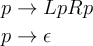

In [2]:
%%latex

\begin{align*}
p &\to LpRp \\
p &\to \epsilon
\end{align*}


where _L_ and _R_ stand in for left and right parentheses, respectively.

A CFG is made up of a series of rules (also called productions or substitutions), each describing how the single symbol to the left of the arrow (the nonterminal symbol) relates to the symbols on the right (a sequence of nonterminals and terminals). In this particular language, _L_, _R_, and _&epsilon;_ are the terminal symbols, so named because they are not described by any rule in the grammar. _p_, meanwhile, is described by a rule, and thus is a nonterminal symbol. (If we had more than one symbol left of an arrow, we'd consider the additional symbols to be restrictions on when the production could be applied--the production, and thus the grammar, would be _context-sensitive_. We're not looking at such languages today.)

For brevity, rules for transforming the same nonterminal are usually collapsed, with alternatives separated by pipe characters, as in:

In [3]:
%%latex
$$ p\to LpRp\  |\  \epsilon $$

For ease of handling in a text editor, we'll use a stripped-down version of the Backus-Nauer Form (BNF) for our grammar notation. Converting to BNF and using more descriptive naming than is typical in mathematical presentations of grammars:

```python
parens :
       | '(' parens ')' parens
```

Note that the &epsilon;-production became the empty production in BNF, placed at the beginning for clarity. (In a CFG, there is no significance attached to the ordering of productions--they can theoretically be tried or applied in any order.)


## Brief Diversion: Regular Grammars

If we were to restrict a CFG such that each production could contain at most one nonterminal, and that symbol could appear only at the right end of the production, we would end up with something called a _right-regular grammar_ (likewise, restricting it to appear at the left end would lead to a left-regular grammar). Such _regular grammars_ produce _regular languages_, the very languages describable by _regular expressions_ and recognizable by _finite state machines_. For example, to describe a run of any number of digits in a regex, we might write,

```perl
/[0-9]*/
```

We could also write a grammar:

```python
digit  : 0 | 1 | 2 | 3 | 4 | 5 | 6 | 8 | 9
digits :
       | digit digits
```

We could also write `digits` to produce a left-regular grammar:

```python
digits :
       | digits digit
```

While it's by now clear that regular languages are a subset of context free languages, it should also be clear that regular expressions are a far more compact notation for specifying them. That said, it's worth keeping this connection mind as a tool for building up more complex regular expressions.

## Back to Balanced Parentheses

Knowing how to describe balanced paren strings, how can we test whether a given string is one? The very simplest thing we could do is to maintain a counter, initialzed at zero, that we increment or decrement on encountering an open or close parenthesis, respectively:

In [4]:
def is_balanced_paren(s):
    opened = 0
    for c in s:
        if c == '(': opened += 1
        elif c == ')': opened -= 1
        else: return False      # illegal character
        if opened < 0: return False  # closed too many
    return opened == 0

Which performs as expected:

In [5]:
def test(fn, *battery):
    width = max(len(case) for case, _ in battery) + 2
    fmt = '%%-%ds gives %%-8s --> %%s' % width

    for (case, expected) in battery:
        result = fn(case)
        success = 'pass' if result == expected else 'fail'
        case_str = "'%s'" % case
        print(fmt % (case_str, result, success))

PAREN_TESTS = [
    ('()()((())())', True),
    ('()()((())()',  False),
    (')(',           False),
    ('',             True),  
]

test(is_balanced_paren, *PAREN_TESTS)

'()()((())())' gives True     --> pass
'()()((())()'  gives False    --> pass
')('           gives False    --> pass
''             gives True     --> pass


With our toy example working, let's motivate something slightly more complex: We'll allow parentheses ('()'), brackets ('[]'), and braces ('{}') in the same string--all balanced. The intuition for the grammar is the same, but now it looks like:

```python
parens :
       | '(' parens ')' parens
       | '[' parens ']' parens
       | '{' parens '}' parens
```

Suddenly a simple counter, or set of counters, won't cut it--the closing braces, brackets, and parentheses must also appear in the proper order. What's called for is a stack:

In [6]:
def is_balanced_parens(s):
    # using a sentinel for end of input lets us avoid  explicit length checks
    end = '$'
    
    stack = [end] 
    s2 = list(s) + [end]
    
    right = dict(('()', '[]', '{}'))
    lefts = set(right)
    for c in s2:
        if c == stack[-1] == end: return True
        elif c == stack[-1]: del stack[-1]
        elif c in right: stack.append(right[c])
        else: return False

Adding some mixed enclosures cases and testing again, we see that everything works properly:

In [7]:
MIXED_ENCLOSURE_TESTS = [
    ('[({}()[[{}]()])(((())))]', True),
    ('[({}()[[{}]()])(((())))',  False)
]

test(is_balanced_parens, *MIXED_ENCLOSURE_TESTS, *PAREN_TESTS)

'[({}()[[{}]()])(((())))]' gives True     --> pass
'[({}()[[{}]()])(((())))'  gives False    --> pass
'()()((())())'             gives True     --> pass
'()()((())()'              gives False    --> pass
')('                       gives False    --> pass
''                         gives True     --> pass


Now that we have an approach that's more generally applicable, let's examine how it works:

* As in the case of our first implementation of an IP address recognizer, there's a tiny bit of state--specifically, there are three states in which the checking process can be:
  * A working state (from invocation right up to return);
  * A failure state (whenever we return `False`)
  * An accepting state (whenever we return `True`)
* The next state is determined by:
  * The current state;
  * The current input symbol; and,
  * The symbol atop the stack.
* As we proceed, we can manipulate the stack based on the selected transition.
  
By bolting a stack onto a state machine, thereby solving the problem of limited memory that constrains normal finite state machines, we've invented a more powerful device, called a Push-Down Automaton (PDA), that can recognize any context-free language--like HTML and regular expression syntax. In more formal treatments, PDAs are specified by a tuple,

In [8]:
%%latex
$$ (Q, \Sigma, \Gamma, \delta, q_0, F) $$

where

* <emph>Q</emph> is a set of states;
* &Sigma; is the input alphabet (i.e., the set of legal input symbols);
* &Gamma; is the stack alphabet (i.e., the set of symbols that can be on the stack);
* &delta;: Q &times; &Sigma;<sub>&epsilon;</sub> &times; &Gamma;<sub>&epsilon;</sub> &rarr; &weierp;(Q &times; &Gamma;<sub>&epsilon;</sub>) is the transition function;
* q<sub>0</sub> &isin; Q is the initial state; and,
* F &subseteq; Q is the set of accepting states.

In our PDA, we know that we have three states (call them "scan", "accept", and "reject") and we know their respective roles. We know the input alphabet (including the '\$' that we append to the input string) and we know the stack alphabet (the closing markers and '\$'). The only thing left is to specify the transition function. In abbreviated form (omitting transitions to the reject state):

| state  | stack | input | stack op | next state
| :---    | :---   | :---   | :---      | :---
| scan   | any   | '('   | push ')' | scan
| scan   | any   | '{'   | push '}' | scan
| scan   | any   | '['   | push ']  | scan
| scan   | ')'   | ')'   | pop      | scan
| scan   | '}'   | '}'   | pop      | scan
| scan   | ']'   | ']'   | pop      | scan
| scan   | \$  | \$  | pop      | accept

This transition function is the program that enables our PDA to recognize the language of interest over the input alphabet. The question that immediately arises when we consider more complex languages is: How can we take a grammar describing a language and come up with a PDA that recognizes it?

## Top-Down Parsing

There are two main approaches to programming a PDA, and therefore parsing context free languages: top-down and bottom up. We'll concern ourselves with top-down for now.

For simplicity, let's go back to the original balanced paren grammar:

```python
parens : 
       | '(' parens ')' parens
```

We have two productions, and we'll restrict ourselves to our favorite three states. Instead of only pushing complementary symbols onto the stack, though, let's try something different: 

1. We'll prime the stack with our single nonterminal.
1. Whenever there's a terminal atop the stack, we'll match it in the input stream, removing it from the stack as we do.
1. Whenever there is a nonterminal atop the stack, we'll replace it with the symbols from the production we expect to use. Because we're ultimately going for replacement with terminals, and since those are matched only when atop the stack, we have to make sure they appear on the top in the proper order. So, we'll push them on from right to left (i.e., opposite their order in the production).

Maybe a transition function will make things clearer:

| state | stack  | input | stack operations | next state | consume input?
| :---   | :---    | :---   | :---       | :---        | :---
| scan  | parens | any   | pop<br>push parens, ')', parens, '(' | scan | no
| scan  | parens | any   | pop       | scan | no
| scan  | '('    | '('   | pop       | scan | yes
| scan  | ')'    | ')'   | pop       | scan | yes
| scan  | \$ | $| pop       | accept | yes

Consider the input string '(())()'. Based on the above, the stack usage and input consumption look like:

| operation  | stack   | unconsumed   | notes
| :---       | :---    | ---:         | :---
| initialize | \$ parens | '(())()' \$ ||
| expand     | \$ parens ')' parens '(' | '(())()' \$ ||
| match      | \$ parens ')' parens | '())()' \$ ||
| expand     | \$ parens ')' parens ')' parens '(' | '())()' \$ ||
| match      | \$ parens ')' parens ')' parens     | '))()' \$ ||
| expand     | \$ parens ')' parens ')'            | '))()' \$ | &epsilon; |
| match      | \$ parens ')' parens                | ')()' \$ ||
| expand     | \$ parens ')'                       | ')()' \$ ||
| match      | \$ parens                           | '()' \$    ||
| expand     | \$ parens ')' parens '('            | '()' \$    ||
| match      | \$ parens ')' parens                | ')' \$    ||
| expand     | \$ parens ')'                       | ')' \$    ||
| match      | \$ parens                           | \$    ||
| expand     | \$                                  | \$    ||
| match      |                                       |     | accept |

Whenever a nonterminal, call it `x`, appears atop the stack, we replace it with a corresponding series of symbols we expect to match in the input; any terminal appearing atop the stack is immediately matched against the input. Once we're done matching all of the symbols that replaced `x`, we're by definition done matching `x` itself, and we can go on matching the next thing (call it `y`). Another way to think about this is that a symbol on the stack is actually a directive to match one of the corresponding productions in the input, and the expansion operation is the first part of how that happens for nonterminals. It's hardly a leap for us to equate the stack expansion of a nonterminal with calling a procedure to match that expansion from the input--in fact, that's the very basis of recursive descent parsing, which is the primary method of writing parsers for context free languages by hand.

## Alternative Views

We're using CFGs to describe strings that are produced by external processes, like human programmers or very chatty sensors. A different view is that one can take a CFG and, beginning with the start symbol, repeatedly apply the various productions to generate different strings in the corresponding context free language. Continuing with the above input and at each step choosing the leftmost nonterminal to expand, the derivation (with &epsilon;'s omitted) would look like:

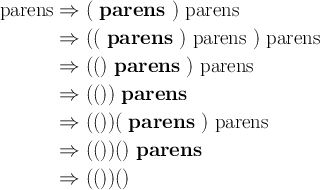

In [9]:
%%latex

\newcommand{\parens}{\mathrm{parens}}
\newcommand{\Parens}{\mathbf{parens}}

\begin{align*}
\parens &\Rightarrow (\ \Parens\ )\ \parens \\
&\Rightarrow ((\ \Parens\ )\ \parens\ )\ \parens \\
&\Rightarrow (()\ \Parens\ )\ \parens \\
&\Rightarrow (())\ \Parens \\
&\Rightarrow (()) (\ \Parens\ )\ \parens \\
&\Rightarrow (()) ()\ \Parens \\
&\Rightarrow (()) () \\
\end{align*}

This _leftmost derivation_ corresponds closely with the actions taken by the PDA we just used to recognize the input string as a member of the balanced-paren language.

A different and more relevant (for us) view is that a CFG provides a means of understanding the structure of utterances in the corresponding language. More than merely recognizing when a string belongs in, for example, `parens`, we want to decompose such a string into its parts--i.e., we wish to _parse_ the string. In the case of our input, '(())()', the _parse tree_ would look like:

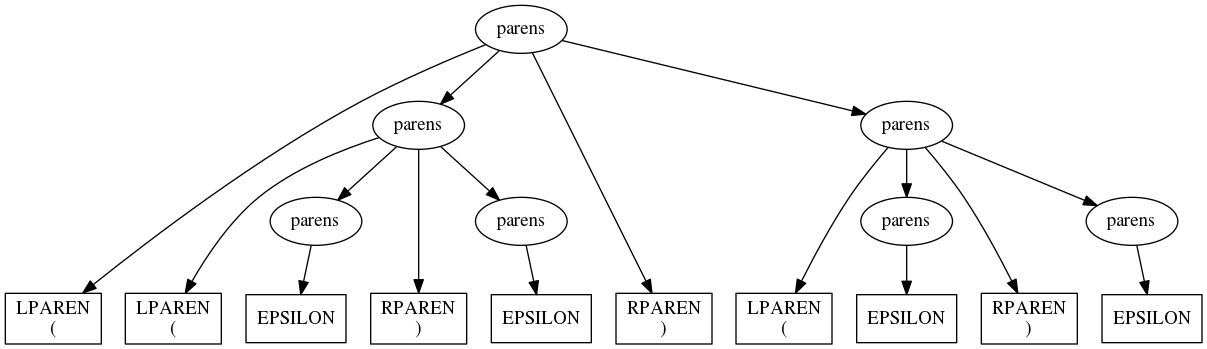

In [10]:
%%dot
digraph g {
color="#ffffffff";
bgcolor="#ffffff00";
node [label="parens", shape="oval"] n_140567907168944;
node [label="LPAREN&#92;n(", shape="rectangle"] n_140567907169560;
node [label="parens", shape="oval"] n_140567907170288;
node [label="LPAREN&#92;n(", shape="rectangle"] n_140567907168328;
node [label="parens", shape="oval"] n_140567907170176;
node [label="EPSILON&#92;n", shape="rectangle"] n_140567907170064;
node [label="RPAREN&#92;n)", shape="rectangle"] n_140567907170960;
node [label="parens", shape="oval"] n_140567907168384;
node [label="EPSILON&#92;n", shape="rectangle"] n_140567907171072;
node [label="RPAREN&#92;n)", shape="rectangle"] n_140567907169000;
node [label="parens", shape="oval"] n_140567907169224;
node [label="LPAREN&#92;n(", shape="rectangle"] n_140567907169056;
node [label="parens", shape="oval"] n_140567907169784;
node [label="EPSILON&#92;n", shape="rectangle"] n_140567907169728;
node [label="RPAREN&#92;n)", shape="rectangle"] n_140567907170904;
node [label="parens", shape="oval"] n_140567907169448;
node [label="EPSILON&#92;n", shape="rectangle"] n_140567907170848;
n_140567907168944 -> n_140567907169560;
n_140567907168944 -> n_140567907170288;
n_140567907170288 -> n_140567907168328;
n_140567907170288 -> n_140567907170176;
n_140567907170176 -> n_140567907170064;
n_140567907170288 -> n_140567907170960;
n_140567907170288 -> n_140567907168384;
n_140567907168384 -> n_140567907171072;
n_140567907168944 -> n_140567907169000;
n_140567907168944 -> n_140567907169224;
n_140567907169224 -> n_140567907169056;
n_140567907169224 -> n_140567907169784;
n_140567907169784 -> n_140567907169728;
n_140567907169224 -> n_140567907170904;
n_140567907169224 -> n_140567907169448;
n_140567907169448 -> n_140567907170848;
n_140567907169560 -> n_140567907168328 [style=invis];
n_140567907168328 -> n_140567907170064 [style=invis];
n_140567907170064 -> n_140567907170960 [style=invis];
n_140567907170960 -> n_140567907171072 [style=invis];
n_140567907171072 -> n_140567907169000 [style=invis];
n_140567907169000 -> n_140567907169056 [style=invis];
n_140567907169056 -> n_140567907169728 [style=invis];
n_140567907169728 -> n_140567907170904 [style=invis];
n_140567907170904 -> n_140567907170848 [style=invis];
{rank=same;n_140567907169560;n_140567907168328;n_140567907170064;n_140567907170960;n_140567907171072;n_140567907169000;n_140567907169056;n_140567907169728;n_140567907170904;n_140567907170848}
}

Each leaf node in the tree is an instance of a terminal symbol from the CFG, and each interior node is an instance of a nonterminal. Generating this structure, either explicitly or logically, is the focus of parsing, also called _syntactic analysis_. Interpreting a parse tree to, for example, generate compiled programs or carry out diabolical doomsday scenarios, is the process of _semantic analysis_. As we'll soon see,

* There is a close correspondence between the structure of a parse tree and the ease of certain kinds of semantic analysis; and,
* It's possible to engineer a CFG for a given language to produce parse trees that are more convenient for the processing that we intend to do.



## Descending, Recursively

In recursive descent parsing, we represent every symbol by a function capable of matching it in the input. Using this approach, our implementation of is_balanced_parens becomes:

In [11]:
# We'll adopt the convention that a parsing function will return, on success,
# a pair (parsed, rest), where
# * parsed is a representation of what was matched from the input, and
# * rest is the remaining input

## terminal parsers

def LPAREN(s):
    'match open paren'
    if s and s[0] == '(': return s[0], s[1:]

def RPAREN(s):
    'match close paren'
    if s and s[0] == ')': return s[0], s[1:]

def EPSILON(s): 
    'match epsilon'
    return '', s

## nonterminals

def parens(s):
    '''
    parens : LPAREN parens RPAREN parens
           | EPSILON
    '''
    
    # Using exception handling for dealing with alternatives keeps our code
    # from marching to the right. Also, note the arrangement: we're starting
    # with the production that will actually try to consume input. This matters
    # because we return the first production that succeeds, and EPSILON never
    # fails.
    
    try:
        # this chaining on rest accomplishes sequential matches
        left,      rest = LPAREN(s)
        p_inside,  rest = parens(rest)
        right,     rest = RPAREN(rest)
        p_outside, rest = parens(rest)
        return (left, p_inside, right, p_outside), rest
    except TypeError:
        return EPSILON(s)
    
def is_balanced_parens(s):
    # Parsing a valid string will consume it entirely.
    parsed, rest = parens(s)
    return rest == ''

And the new `is_balanced_parens` responds as expected:

In [12]:
test(is_balanced_parens, *PAREN_TESTS)

'()()((())())' gives True     --> pass
'()()((())()'  gives False    --> pass
')('           gives False    --> pass
''             gives True     --> pass


## Basic Expression Parsing

Let's try something more ambitious: parsing simple mathematical expressions. The nonterminals will be:

* `OPERATOR`s: '+', '-', '*', and '/';
* `NUMBER`s; and,
* Open and close parentheses (`LPAREN` and `RPAREN`, respectively).

The very simplest thing we can try is to simply say something like:

```python
expression : expression OPERATOR expression
           | LPAREN expression RPAREN
           | NUMBER
```

Simple, right?

Before translating this to code, let's take a few minutes to implement better tools for constructing recursive descent parsers. The exception-based implementation of `parens` above is horrible. What we really want is to write code that looks more like the grammar. Without going all the way to producing callable objects composable under various operations:

In [13]:
import re

## utilties for making terminal parsers

def match(spec, s):
    'match a regular expression spec in s, skipping leading whitespace'
    s = s.lstrip()
    x = re.match(spec, s)
    if x: return s[:x.end()], s[x.end():]

def literal(spec, s):
    'match a literal string spec in s, skipping leading whitespace'
    s = s.lstrip()
    n = len(spec)
    if s[:n] == spec: return spec, s[n:]

## utilities for making nonterminal parsers

def seq(*syms):
    'return a parser that matches sequences of symbols'
    def parse(s):
        acc = []
        rest = s
        for sym in syms:
            x = sym(rest)
            if not x: return False
            matched, rest = x
            acc.append(matched)
        return acc, rest
    return parse

def alt(*syms):
    'return a parser that matches alternatives (first match wins)'
    def parse(s):
        for sym in syms:
            x = sym(s)
            if x: return x
        return False
    return parse
    
def parse(start, s):
    'match only if all input is consumed'
    x = start(s)
    if x:
        matched, rest = x
        if rest.strip() == '': return matched

Also, let's create a few utilities to simplify handling the parse trees that we'll create:

In [14]:
# Time spent on a nice printable representation of complex data structures 
# repays itself at debugging time.

def indent(s, tab='    '): return tab + s.replace('\n', '\n' + tab)

class symbol:
    def __init__(self, type_, value, terminal=False):
        self.type = type_
        self.value = value
        self.terminal = terminal
        
        if not self.terminal and type(self.value) != list: 
            self.value = [self.value]
            
    def __repr__(self):
        if self.terminal: return f"{self.type}: '{self.value}'"
        else:
            header = self.type + ':'
            body = '\n'.join(map(repr, self.value))
            
            if body.count('\n') == 0: return header + ' ' + body
            else: return header + '\n' + indent(body)

class parse_result(tuple):
    def __repr__(self):
        return '''
        parse
        =====
        %s
        
        unconsumed
        ==========
        %s
        '''.replace('''
        ''', '\n') % self

class parser:
    def __init__(self, f, terminal=None):
        self.f = f
        if terminal == None:
            # as convenience, infer terminality by f's name being all caps
            self.terminal = f.__name__ == f.__name__.upper()
        else:
            self.terminal = terminal
        
    def __call__(self, s):
        x = self.f(s)
        
        if x: 
            matched, rest = x
            sym = symbol(self.f.__name__, matched, self.terminal)
            return parse_result((sym, rest))

Applying these to the balanced paren language, we get:

In [15]:
## Terminals

@parser
def LPAREN(s):
    'match open paren'
    if s and s[0] == '(': return s[0], s[1:]

@parser
def RPAREN(s):
    'match close paren'
    if s and s[0] == ')': return s[0], s[1:]

@parser
def EPSILON(s): 
    'match epsilon'
    return '', s

## Nonterminals

@parser
def parens(s):
    '''
    parens : LPAREN parens RPAREN parens
           | EPSILON
    '''
    return alt(seq(LPAREN, parens, RPAREN, parens), 
               EPSILON)(s)

Turning `parens` on the string '(())()' results in the parse tree we saw before:

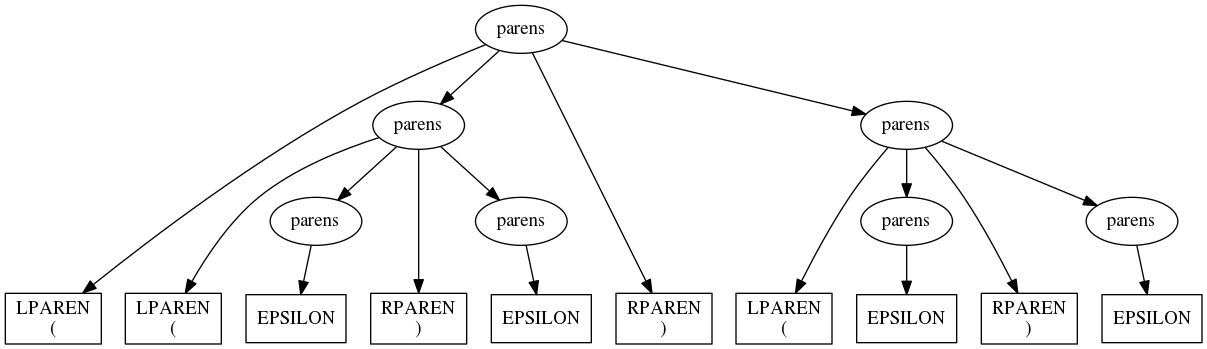

In [16]:
parse_tree(*parens('(())()'))

Now we're ready to translate our simple expression grammar into code:

In [17]:
@parser
def NUMBER(s): return match('\d+', s)

@parser
def OPERATOR(s): return match('[+*/-]', s)

@parser
def expression(s):
    '''
    expression : expression OPERATOR expression
               | LPAREN expression RPAREN
               | NUMBER
    '''
    return alt(seq(expression, OPERATOR, expression),
               seq(LPAREN, expression, RPAREN),
               NUMBER)(s)

Testing it on a simple addition reveals a problem, though:

In [18]:
expression('4 + 5 + 6')

RecursionError: maximum recursion depth exceeded

What's happened is that the very first production tested,

```python
expression : expression OPERATOR expression
```

led to a call to `expression` without consuming any input; that led to another call, and so, until we destroyed our call stack. This _left recursive_ production in the grammar led to infinite recursion in the parser, and there's no mere trick of implementation that will get rid of it. We have to revisit the grammar itself.

Suppose we came up with the concept of a subexpression, or `subex`, which would represent anything that could be combined with other `subex`es using an `OPERATOR`. We could then say that an `expression` is nothing more than a series of `subex`es separated by `OPERATOR`s. If a `subex` is just a `NUMBER` or an `expression` enclosed in parentheses,

```python
expression : subex OPERATOR expression
           | subex

subex : NUMBER
      | LPAREN expression RPAREN
```

This kind of transformation is sufficient to break the left recursion. While it's not strictly necessary, further factoring can often make life easier later. For example, there are two type of `subex`es:

```python
enclosed   : LPAREN expression LPAREN

subex : NUMBER | enclosed
```

Now to revisit the implementation:

In [19]:
@parser
def expression(s):
    '''
    expression : subex OPERATOR expression
               | subex
    '''
    return alt(seq(subex, OPERATOR, expression), 
               subex)(s)

@parser
def subex(s): 
    'subex : NUMBER | enclosed'
    return alt(NUMBER, enclosed)(s)

@parser
def enclosed(s): 
    'enclosed : LPAREN expression RPAREN'
    return seq(LPAREN, expression, RPAREN)(s)

Calling `expression('4 + 5*6 - 7')` generates the following parse tree:

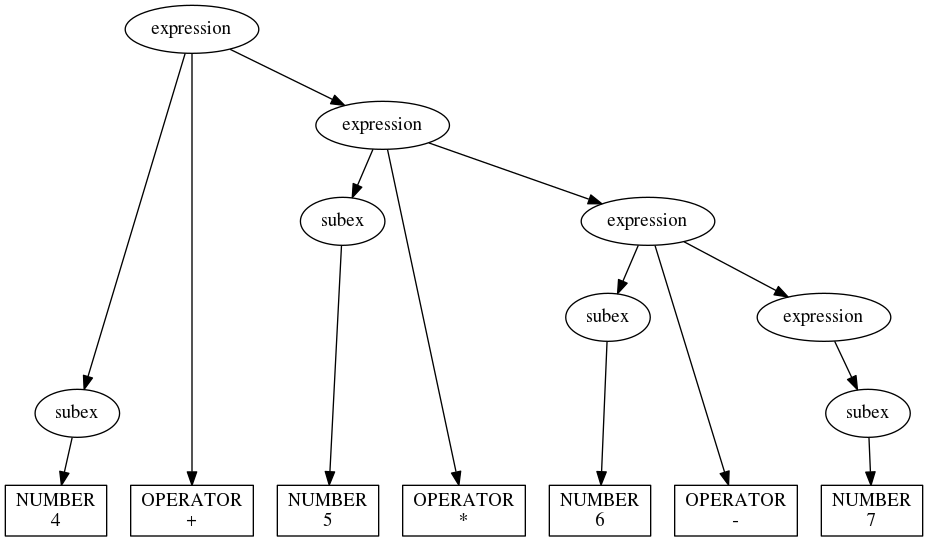

In [20]:
parse_tree(*expression('4 + 5*6 - 7'))

Okay, we've fixed the left recursion problem only to highlight a new one: We know that 

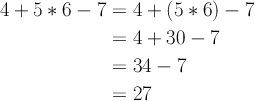

In [21]:
%%latex
\begin{align*}
4 + 5*6 - 7 &= 4 + (5*6) - 7 \\
&= 4 + 30 - 7 \\
&= 34 - 7 \\
&= 27
\end{align*}

In general, parse trees are interpreted from the bottom up, with the tightest constructs evaluated first (i.e., by postorder traversal). Applying this to the parse tree we just generated, we see that it really describes

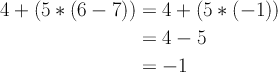

In [22]:
%%latex
\begin{align*}
4 + (5 * (6 - 7)) &= 4 + (5*(-1)) \\
&= 4 - 5 \\
&= -1
\end{align*}

which is wrong. 

The issue here is that our grammar says nothing about operator precedence. We can fix this is by elaborating the notion of an `expression` further: We'll now treat it as a series of `term`s combined under addition and subtraction. Each `term` will then consist of one or more `factor`s, multiplied or divided:

```python
expression : term ADDOP expression
           | term
           
term : factor MULOP term
     | factor
     
factor : NUMBER | enclosed
```

where `ADDOP` represents the additive operators (+ and -) and `MULOP` represents the multiplicative operators (* and /).

Adapting our parser:

In [23]:
@parser
def ADDOP(s): return match('[+-]', s)

@parser
def MULOP(s): return match('[*/]', s)

@parser
def expression(s):
    '''
    expression : term ADDOP expression
               | term
    '''
    return alt(seq(term, ADDOP, expression), 
               term)(s)

@parser
def term(s):
    '''
    term : factor MULOP term
         | factor
    '''
    return alt(seq(factor, MULOP, term), 
               factor)(s)

@parser
def factor(s): 
    'factor : NUMBER | enclosed'
    return alt(NUMBER, enclosed)(s)

And now `expression` correctly parses the test string:

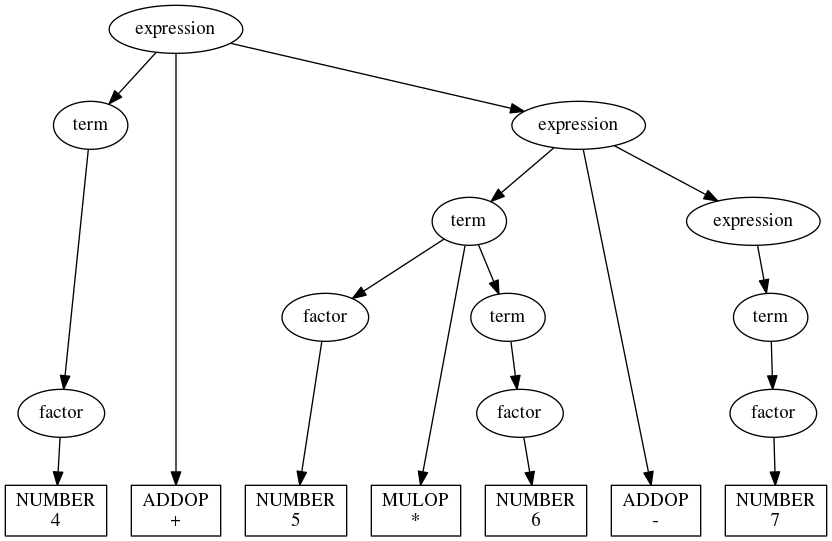

In [24]:
parse_tree(*expression('4 + 5*6 - 7'))

So far, so good, but another problem lurks: Associativity. The parse tree that `expression` generates for `'1 - 2 - 3' ` is:

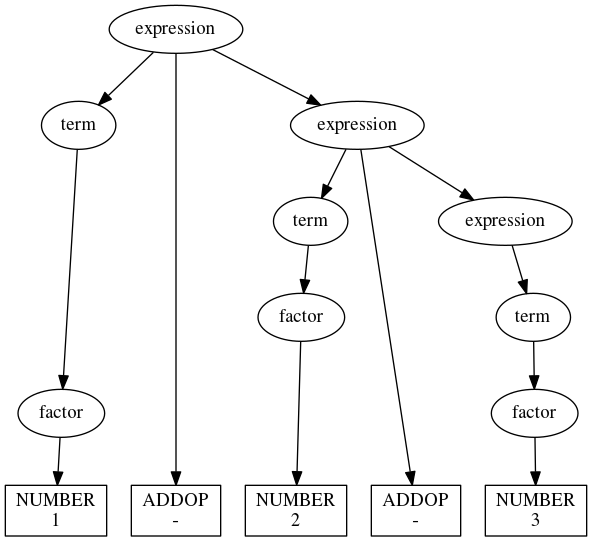

In [25]:
parse_tree(*expression('1-2-3'))

This parse tree says that 1-2-3 = 1-(2-3) = 2, which we know to be incorrect. The problem is that subtraction is _left associative_ (as is division), while our grammar has all operators as right associative. We can fix this by changing the grammar yet again, arriving at something closer to the second expression grammar that we had (when we cured the left recursion). 

Think of an expression as a starting term followed by a series of increments:

```python
expression : term increments

increments :
           | increment increments
```

Each increment consists of an operation (either addition or subtraction) and a term:

```python
increment : ADDOP term
```

Likewise, each term is composed of a starting factor followed by a series of scalings, each composed of an operation (multiplication or division) and a factor:

```python
term : factor scalings

scalings :
         | scaling scalings
         
scaling : MULOP factor
```
With this,

In [26]:
@parser
def expression(s):
    'expression : term increments'
    return seq(term, increments)(s)

@parser
def increments(s): 
    '''
    increments : 
               | increment increments
    '''
    return alt(seq(increment, increments), 
               EPSILON)(s)

@parser
def increment(s): 
    'increment : ADDOP term'
    return seq(ADDOP, term)(s)

@parser
def term(s): 
    'term : factor scalings'
    return seq(factor, scalings)(s)

@parser
def scalings(s): 
    '''
    scalings :
             | scaling scalings
    '''
    return alt(seq(scaling, scalings), 
               EPSILON)(s)

@parser
def scaling(s): 
    'scaling : MULOP factor'
    return seq(MULOP, factor)(s)

@parser
def factor(s): 
    'factor : NUMBER | enclosed'
    return alt(NUMBER, enclosed)(s)

@parser
def enclosed(s): 
    'enclosed : LPAREN expression RPAREN'
    return seq(LPAREN, expression, RPAREN)(s)

We can now build a parse tree for 1-2-3 that accurately describes what we need to do to correctly evaluate it:

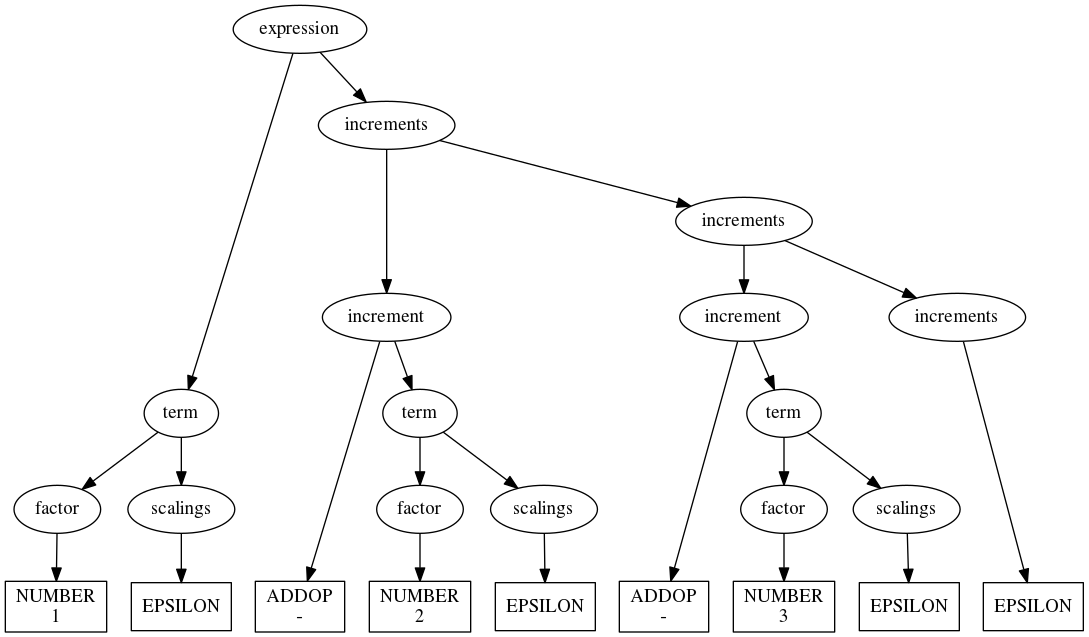

In [27]:
parse_tree(*expression('1 - 2 - 3'))

We could even perform some processing of this tree to build a rudimentary calculator. In fact, let's do that. 

There are a couple of perfectly good options for evaluating expressions based on our parser:

* We could process the tree after it's finished, explicitly performing a post-order traversal and propagating intermediate results upward.
* We could outfit the parsers with callback routines that are triggered immediately on matching the associated symbols.

The latter option is referred to as _syntax-directed translation_, since the parser drives the entire translation process (think of evaluation as the process of translating an expression to a final value). Since syntax-directed translation is more common in compiler design, and because it's an elegant approach, we'll go that way. Let's start by adding to `parser`:

In [28]:
class parser(parser):
    def on(self, handler): 
        'set a symbol handler'
        self.handler = handler
        
    def __call__(self, s):
        x = self.f(s)
        if x: 
            matched, rest = x
            sym = symbol(self.f.__name__, matched, self.terminal)
            
            # call the symbol handler if present
            if hasattr(self, 'handler'): self.handler(sym)
            
            return parse_result((sym, rest))

For ease of reference, I'll collect everything needed to describe expressions here:

In [29]:
## terminals

@parser
def ADDOP(s): return match('[+-]', s)

@parser
def MULOP(s): return match('[*/]', s)

@parser
def NUMBER(s): return match('\d+', s)

@parser
def LPAREN(s): return literal('(', s)

@parser
def RPAREN(s): return literal(')', s)

## nonterminals

@parser
def expression(s):
    'expression : term increments'
    return seq(term, increments)(s)

@parser
def increments(s):
    'increments : { increment }'
    return alt(seq(increment, increments), EPSILON)(s)
    return rep(increment)(s)

@parser
def increment(s): 
    'ADDOP term'
    return seq(ADDOP, term)(s)

@parser
def term(s): 
    'factor scalings'
    return seq(factor, scalings)(s)

@parser
def scalings(s): 
    '{ scaling }'
    return alt(seq(scaling, scalings), EPSILON)(s)
    return rep(scaling)(s)

@parser
def scaling(s): 
    'MULOP factor'
    return seq(MULOP, factor)(s)

@parser
def factor(s): 
    'NUMBER enclosed'
    return alt(NUMBER, enclosed)(s)

@parser
def enclosed(s): 
    'LPAREN expression RPAREN'
    return seq(LPAREN, expression, RPAREN)(s)

That done, and after redefining our parsers, we can write handlers for each symbol we care to process. Tagging each symbol with a `result` attribute accumulated up the parse tree:

In [30]:
from functools import reduce
from operator import mul

def product(xs): return reduce(mul, xs, 1)

@NUMBER.on
def h_NUMBER(sym): sym.result = int(sym.value)    

@enclosed.on
def h_enclosed(sym): sym.result = sym.value[1].result
    
@factor.on
def h_factor(sym): sym.result = sym.value[0].result
    
@scaling.on
def h_scaling(sym):
    op, mag_ = sym.value
    mag = mag_.result
    sym.result = mag if op.value == '*' else 1/mag

@scalings.on
def h_scalings(sym):
    if sym.value[0].type == 'EPSILON': sym.result = 1
    else:
        sym.result = sym.value[0].result * sym.value[1].result
    
@increment.on
def h_increment(sym):
    op, mag_ = sym.value
    mag = mag_.result
    sym.result = mag if op.value == '+' else -mag

@increments.on
def h_increments(sym):
    if sym.value[0].type == 'EPSILON': sym.result = 0
    else:
        sym.result = sym.value[0].result + sym.value[1].result
    
@term.on
def h_term(sym):
    a, b = sym.value
    sym.result = a.result * b.result
    
@expression.on
def h_expression(sym):
    a, b = sym.value
    sym.result = a.result + b.result

A few test cases, including the troubling expressions from before, give us confidence that we're properly evaluating positive integer arithmetic:

In [31]:
def calc(s): return expression(s)[0].result

test(calc,
     ('4 + 5*6 - 7', 4 + 5*6 - 7),
     ('1 - 2 - 3',   1 - 2 - 3),
     ('(30 + 40)/(3 + 4)',  (30 + 40)/(3 + 4))
    )

'4 + 5*6 - 7'       gives 27       --> pass
'1 - 2 - 3'         gives -4       --> pass
'(30 + 40)/(3 + 4)' gives 10.0     --> pass


## Parsing BNF Grammars

Now that we have a straightforward way to produce recursive descent parsers from BNF grammars by inspection, let's try a useful party trick: Let's parse our BNF grammars. 

As we've seen, a grammar is a series of rules (we'll insist on having at least one):

```python
rules : rule rules
      | rule
```

Each rule consists of a name and a series of alternative productions, with appropriate delimiters:

```python
rule : IDENTIFIER COLON productions

productions : production PIPE productions
            | production
```

And, finally, a production is nothing more than a series of symbols to substitute for the nonterminal being defined:

```python
production :
           | production
```

Given these definitions, it should be trivial to write a parser by inspection with the tools we have, yes? Let's try.

In [32]:
## terminals

@parser
def IDENTIFIER(s): return match('[a-zA-Z_][\w_]*', s)

@parser
def COLON(s): return literal(':', s)

@parser
def PIPE(s): return literal('|', s)

## nonterminals

@parser
def rules(s):
    '''
    rules :
          | rule rules
    '''
    return alt(seq(rule, rules), 
               EPSILON)(s)

@parser
def rule(s): 
    'rule : IDENTIFIER COLON productions'
    return seq(IDENTIFIER, COLON, productions)(s)

@parser
def productions(s):
    '''
    productions : production PIPE productions
                | production
    '''
    return alt(seq(production, PIPE, productions), 
               production)(s)

@parser
def production(s):
    '''
    production : 
               | IDENTIFIER production               
    '''
    return alt(seq(IDENTIFIER, production),
               EPSILON)(s)

When we run this on a simple grammar, say,

```python
a : b c d
d : e f
```

we encounter a problem:

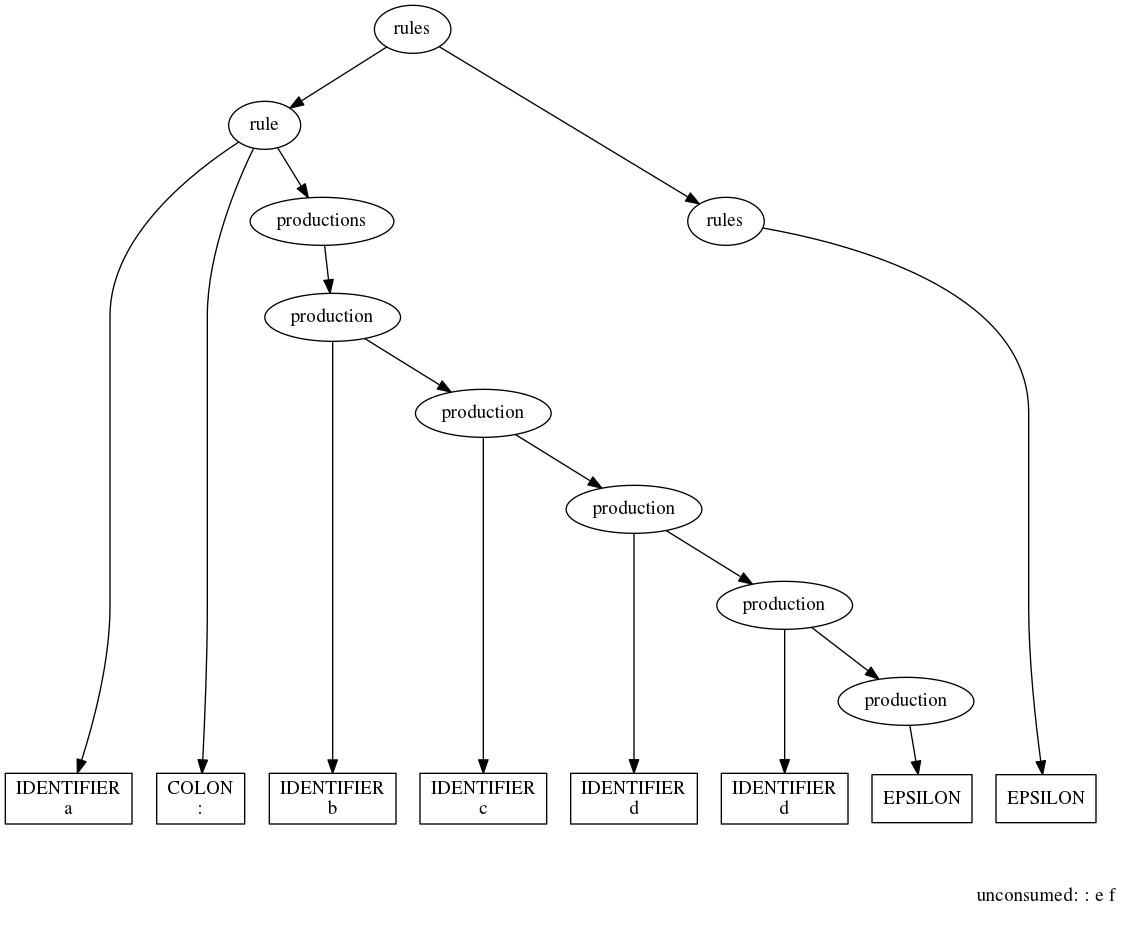

In [33]:
parse_tree(
*rules('''
a : b c d
d : e f
''')
)

The unconsumed input begins with a colon--it seems that somewhere in the parsing process we're grabbing the `IDENTIFIER` that begins a rule definition (in this case 'd') and appending it to the previous production. In fact, this very statement suggests a hypothesis we can test: That `production` is too greedy:

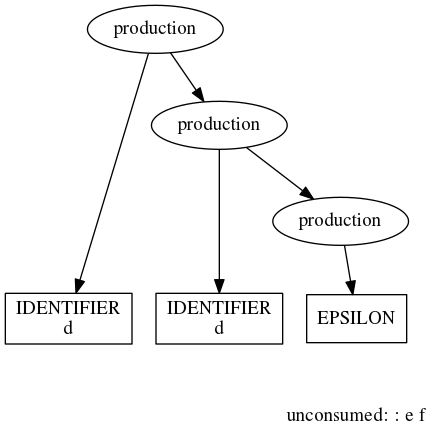

In [34]:
parse_tree(*
production('''
d
d: e f
''')
)

The problem is that there are two roles that `IDENTIFIER`s can play--to start rule definitions and to reference rules defined elsewhere--and our BNF grammar for BNF grammars allows the interpretation of an `IDENTIFIER` to shift from one position to the next without any intervening marker, like an explicit delimiter indicating the end of a rule. We have some options for fixing this:

* We can add such a delimiter, e.g., a semicolon.
* We can separate out the terminal parsers and run them over the input stream before the nonterminal parsers, thereby transforming the input stream into a stream of tokens (this is called lexical analysis, or lexing). That done, we can add to the grammar a new terminal, say, `RULE_NAME`, to absorb the colon; this terminal would only be used for introducing a rule definition.
* We can elaborate the `production` parser to check whether a colon follows an `IDENTIFIER` that it's about to consume and, if so, not consume it. This strategy is called lookahead.
* Finally, we can elaborate the entire parsing process to incorporate a mechanism for generating all possible parses that consume any amount of the input stream. This strategy is called backtracking.

Adding a rule-end delimiter is an easy fix, and it's a good one--it transforms the grammar into something that can be parsed very efficiently with the tools we already have. However, the task before us is to parse the BNF notation that we're using. The approach of using a separate lexer and a grammar to take advantage of it would enable us to meet our objective, but it introduces more complexity than is actually required to do this job.

Having rejected the first two options, let's consider the next.

## Lookahead

The basic problem, as discussed, is that `production` is grabbing `IDENTIFIER`s without considering whether they might be introducing a new rule, something that could be determined by looking ahead one more token to see if a colon is there. It is very easy to modify the existing code to use this approach. First, let's define a couple of functions to perform arbitrary lookahead without actually consuming input:

In [35]:
def follow(sym):
    def ret(s):
        if sym(s): return EPSILON(s)
    return ret

def nofollow(sym):
    def ret(s):
        if not sym(s): return EPSILON(s)
    return ret

Then, we just have to change `production` to check that a colon doesn't immediately follow:

In [38]:
@parser
def production(s):
    '''
    production :
               | IDENTIFIER production
    '''
    return alt(seq(IDENTIFIER, production, nofollow(COLON)),
               EPSILON)(s)

Keep in mind that adding the lookahead parser to the first production introduces an additional `EPSILON` in the corresponding parse. Parsing the test grammar with `rules` now produces the following parse tree:

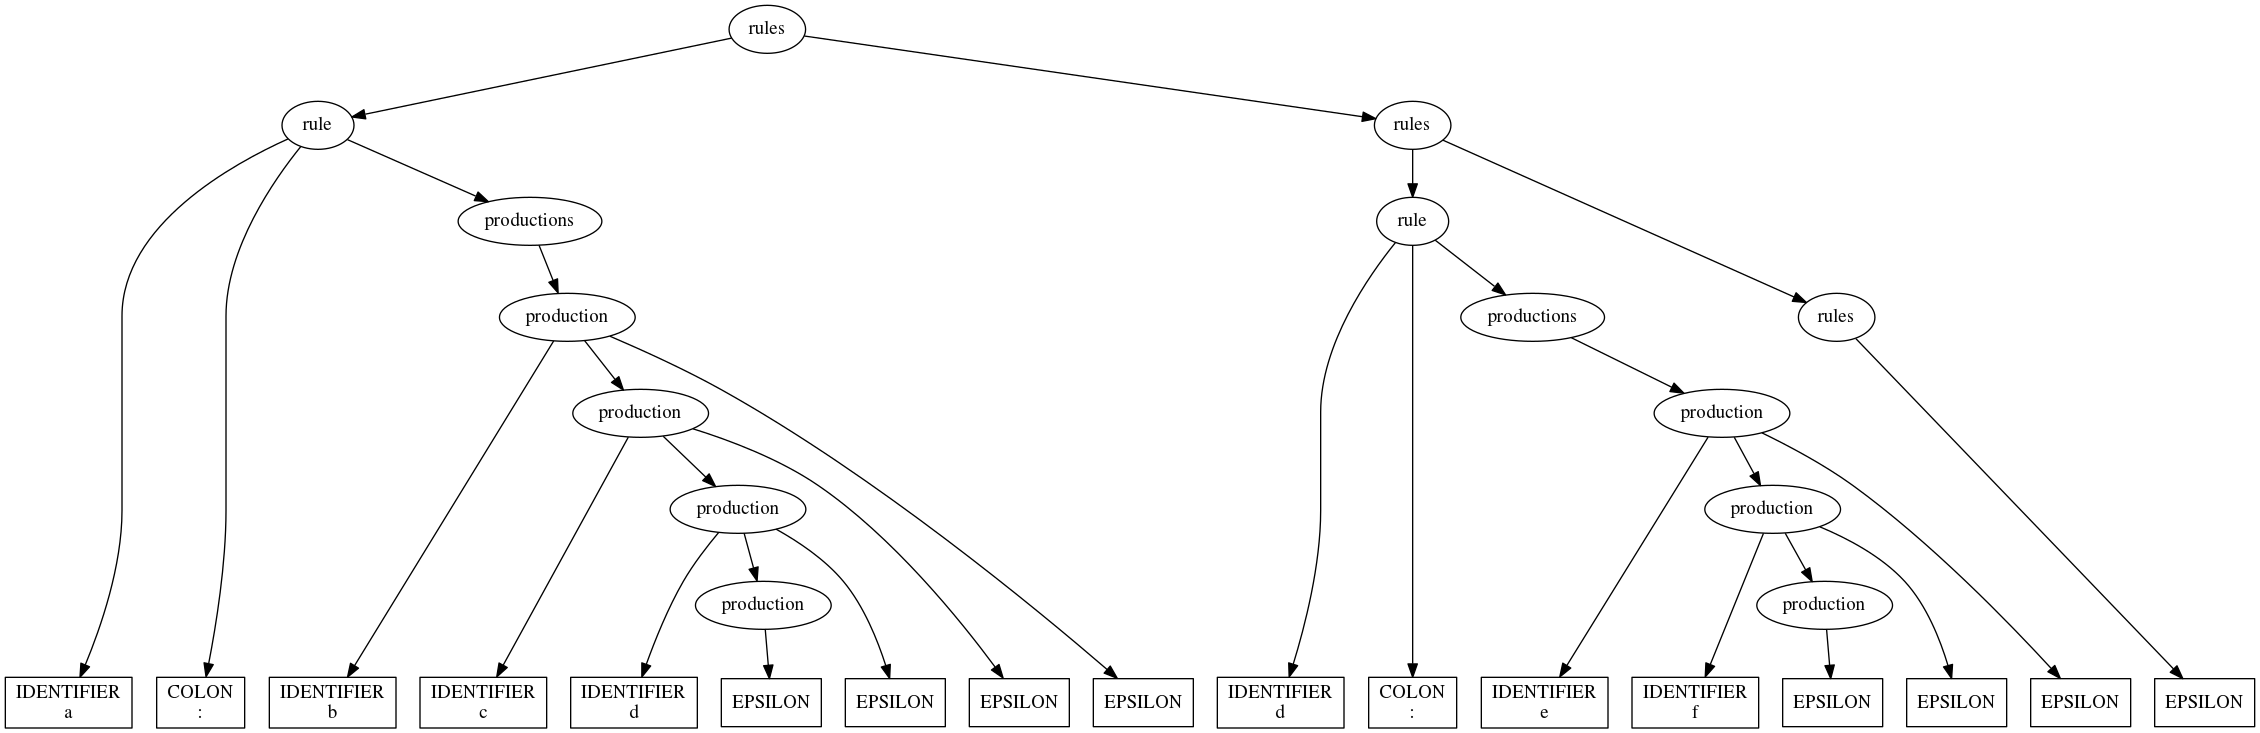

In [39]:
parse_tree(
*rules('''
a : b c d
d : e f
''')   
)

And just like that, we've fixed our immediate problem of sorting out the proper role of an IDENTIFIER when we spot one. It also turns out that this technique can be applied to smooth over most problems that crop up in practical parsing applications, and it can yield very efficient parsers.

For the curious, the parse tree for our expression grammar looks like:

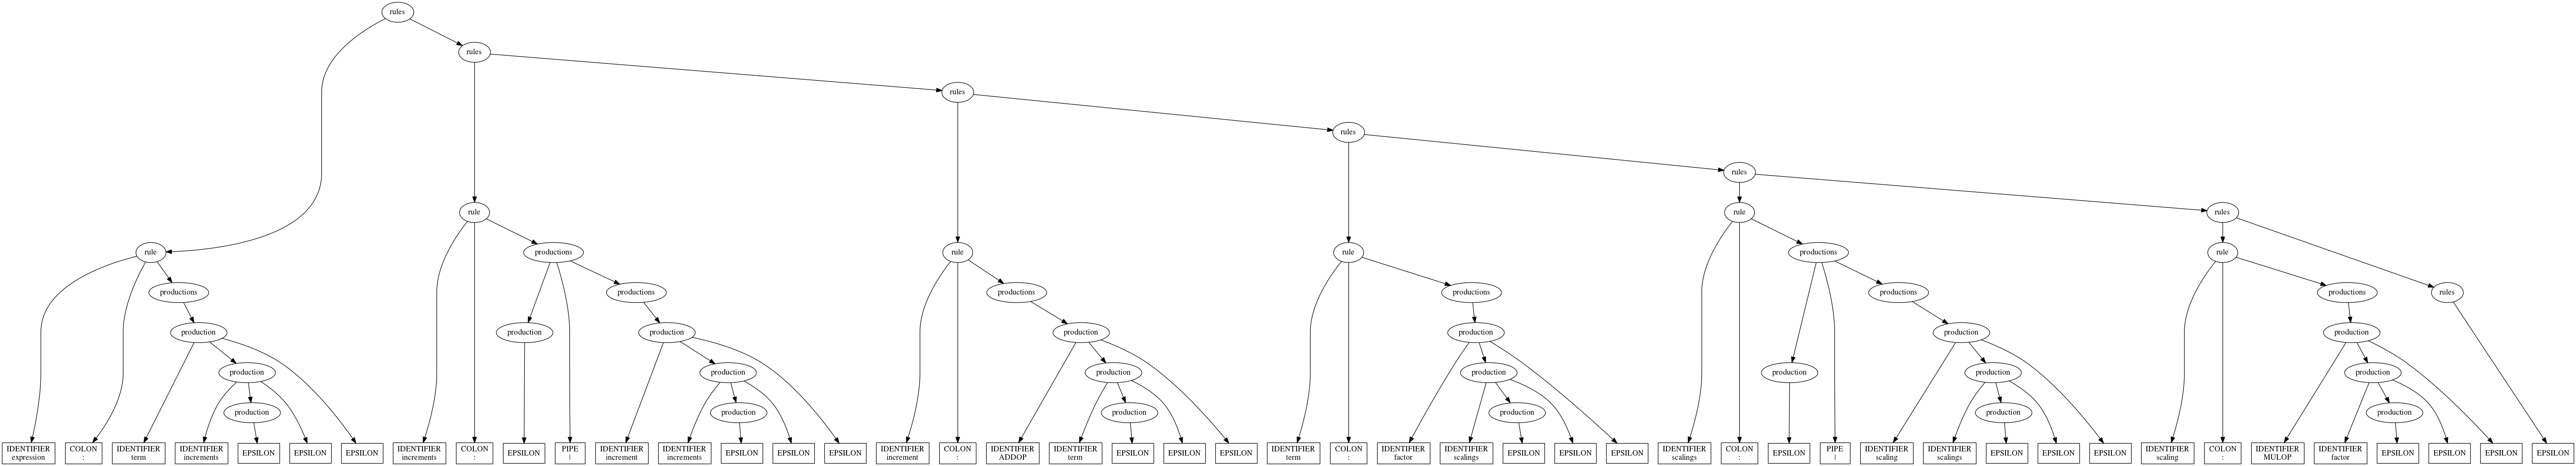

In [40]:
parse_tree(
*rules('''
expression : term increments

increments :
           | increment increments

increment : ADDOP term

term : factor scalings

scalings :
         | scaling scalings

scaling : MULOP factor
''')
)

## Expressions Revisited

The expression evaluator is nice, but there's no substitute for the power of a full programming language. We won't go that far right now, but let's consider what it would take to:

* Allow assignment and references of variables; and,
* Evaluate sequences of statements.

First, let's come up with a syntax for assigning the result of an expression to a variable:

```python
assignment: IDENTIFIER EQUALS expression
```

To allow using previously defined variables in expressions, let's introduce the concept of a `reference` and find a logical place in the grammar to add it:

```python
reference: IDENTIFIER

factor: NUMBER | enclosed | reference
```

Without the idea of multiple `statement`s, executed in sequence, the presence of variables in our language is a bit nonsensical, so let's fix that:

```python
statements: statement statements
          | statement
          
statement: assignment | expression
```

That's it. Together with the rest of our expression grammar defined as before, we're ready to think about implementing the parser. Defining the following parsing functions:

In [41]:
## new terminals

@parser 
def EQUALS(s): return literal('=', s)

## new nonterminals

@parser
def statements(s):
    '''
    statements : statement statements
               | statement
    '''
    return alt(seq(statement, statements), statement)(s)

@parser
def statement(s):
    'statement : assignment | expression'
    return alt(assignment, expression)(s)

@parser
def assignment(s):
    'assignment : IDENTIFIER EQUALS expression'
    return seq(IDENTIFIER, EQUALS, expression)(s)

@parser
def reference(s): 
    'reference : IDENTIFIER'
    return IDENTIFIER(s)

And modifying one more:

In [42]:
## modified nonterminals

@parser
def factor(s): 
    'NUMBER | enclosed | reference'
    return alt(NUMBER, enclosed, reference)(s)

We don't have to touch the remaining parsing functions.

In [43]:
## terminals

@parser
def ADDOP(s): return match('[+-]', s)

@parser
def MULOP(s): return match('[*/]', s)

@parser
def NUMBER(s): return match('\d+', s)

@parser
def LPAREN(s): return literal('(', s)

@parser
def RPAREN(s): return literal(')', s)

@parser
def IDENTIFIER(s): return match('\w+', s)


## nonterminals


@parser
def expression(s):
    'expression : term increments'
    return seq(term, increments)(s)

@parser
def increments(s):
    '''
    increments : 
               | increment increments
    '''
    return alt(seq(increment, increments), EPSILON)(s)

@parser
def increment(s): 
    'ADDOP term'
    return seq(ADDOP, term)(s)

@parser
def term(s): 
    'factor scalings'
    return seq(factor, scalings)(s)

@parser
def scalings(s): 
    '''
    scalings :
             | scaling scalings
    '''
    return alt(seq(scaling, scalings), EPSILON)(s)

@parser
def scaling(s): 
    'MULOP factor'
    return seq(MULOP, factor)(s)



@parser
def enclosed(s): 
    'LPAREN expression RPAREN'
    return seq(LPAREN, expression, RPAREN)(s)

Now we're ready for a quick test:

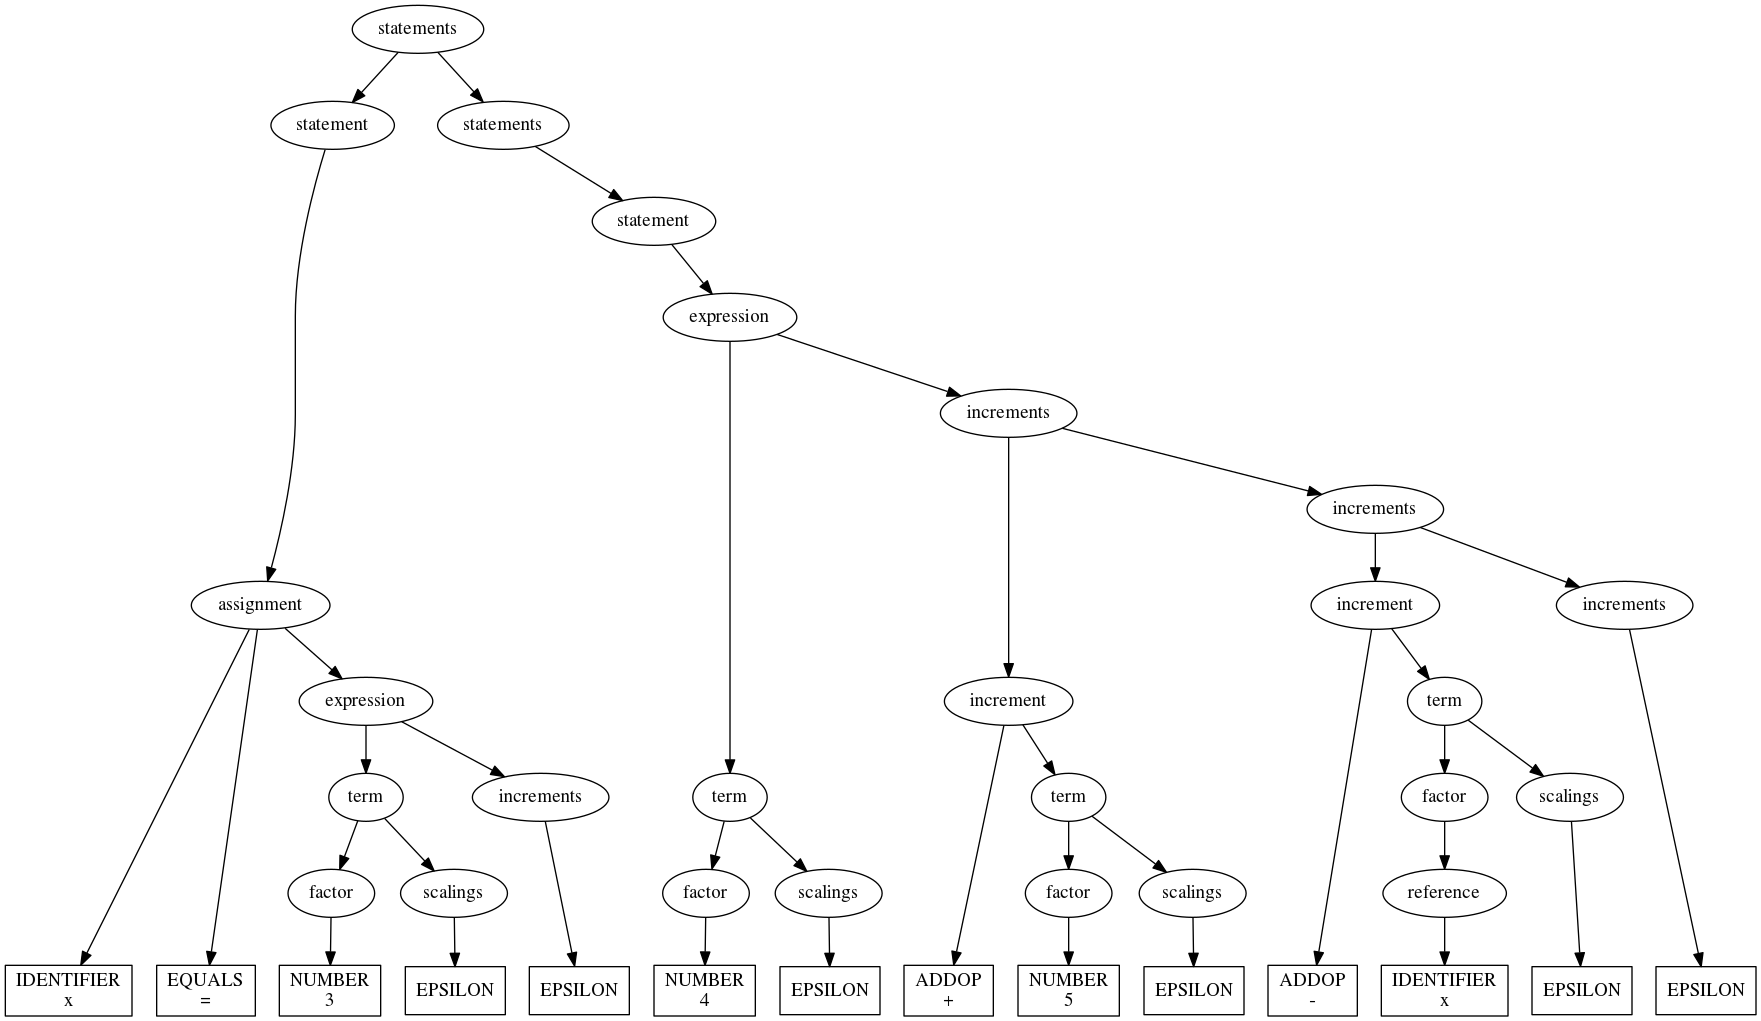

In [44]:
parse_tree(
*statements('''
x = 3 
4+5 - x
''')
)

With our newfound ability to comprehend a simple, Turing-incomplete language, let's write a simple interpreter for it. As before, we'll need handlers for the parsing functions. What's different this time is that we need a place to store defined variables, and it has to be accessible by the handlers for both `reference` and `assignment`. We also need to decide the proper course of action for referencing a variable before it's been assigned a value.

If we decide that referencing unassigned variables should generate an error, the handlers for `assignment` and reference might look like:

In [45]:
variables = {}

@assignment.on
def h_assignment(sym):
    name, _, val = sym.value
    variables[name.value] = val.result
    sym.result = val.result

@reference.on
def h_reference(sym): 
    name = sym.value[0].value
    if name not in variables: raise NameError(name)
    else: sym.result = variables[name]

Now to handle statements. Taking the value of the last statement in a sequence as being the value of the entire sequence (a pretty conventional approach),

In [46]:
@statement.on
def h_statement(sym): sym.result = sym.value[0].result
    
@statements.on
def h_statements(sym):
    if len(sym.value) == 1: sym.result = sym.value[0].result
    else: sym.result = sym.value[1].result
        

The handlers for the remaining symbols can be just as they were.

In [47]:
@NUMBER.on
def h_NUMBER(sym): sym.result = int(sym.value)    

@enclosed.on
def h_enclosed(sym): sym.result = sym.value[1].result
    
@factor.on
def h_factor(sym): sym.result = sym.value[0].result
    
@scaling.on
def h_scaling(sym):
    op, mag_ = sym.value
    mag = mag_.result
    sym.result = mag if op.value == '*' else 1/mag

@scalings.on
def h_scalings(sym):
    if sym.value[0].type == 'EPSILON': sym.result = 1
    else:
        sym.result = sym.value[0].result * sym.value[1].result
    
@increment.on
def h_increment(sym):
    op, mag_ = sym.value
    mag = mag_.result
    sym.result = mag if op.value == '+' else -mag

@increments.on
def h_increments(sym):
    if sym.value[0].type == 'EPSILON': sym.result = 0
    else:
        sym.result = sym.value[0].result + sym.value[1].result
    
@term.on
def h_term(sym):
    a, b = sym.value
    sym.result = a.result * b.result
    
@expression.on
def h_expression(sym):
    a, b = sym.value
    sym.result = a.result + b.result

For convenience, let's use our evaluator as the basis for a little interpreter. We don't have to limit statements to one line each, but it's simpler if we do. Also, we need to check that each line is entirely consumed--if it isn't, there's a syntax error for us to report. With these in mind:

In [49]:
variables = {}

while True:
    line = input('stmt> ').strip()
    if not line: break
    try:
        p = val, rest = statement(line)
        print(val.result)
        if rest.strip():
            pos = len(line) - len(rest)
            print('syntax error at pos. %s' % pos)
            print(p)
    except Exception as e:
        print(e.__class__, e.args)

stmt> 4 + 5*6 - 7
27
stmt> 1 - 2 - 3
-4
stmt> x - 4
<class 'NameError'> ('x',)
stmt> x = 5
5
stmt> x - 4
1
stmt> (30 + x*10) / 7
11.428571428571427
stmt> x = 4
4
stmt> (30 + x*10) / 7
10.0
stmt> 1 - 2 -
-1
syntax error at pos. 5

parse
=====
statement:
    expression:
        term:
            factor: NUMBER: '1'
            scalings: EPSILON: ''
        increments:
            increment:
                ADDOP: '-'
                term:
                    factor: NUMBER: '2'
                    scalings: EPSILON: ''
            increments: EPSILON: ''

unconsumed
 -

stmt> x/(x-x)
<class 'ZeroDivisionError'> ('division by zero',)
stmt> x = 3*x
12
stmt> x
12
stmt> 


## Wrapping Up

Our little interpreter leaves a great deal to be desired--even though it performs real arithmetic, it only accepts positive integers in its input; it only implements four basic operations; it has no looping or decision constructs; it lacks useful functions like `sin`, `cos`, and `log`; etc. Even so, because of the path we took in creating it, we can imagine how we might approach modifying the language to include at least some of the features we want, as well as how we might go about bringing those features into being.

When we first started, we couldn't even properly handle nested parentheses, something required for a functioning regex engine. Now we can engineer context free grammars to produce parse trees that have desirable properties; use syntax-directed translation to perform computations using those trees; and implement simple interpreters with passable error detection and recovery. Along the way, we invented a computational model, the pushdown automaton (PDA); figured out a reasonable method for programming it; and used our understanding of its operation to devise a practical approach for writing parsers for deterministic context free languages by hand, with an array of little utilities to help us make short work of such a task.

There's a bit more in the land of recursive descent parsing to cover, like backtracking, EBNF, and parser generators, but we're at a natural stopping point. With that, let's stop for now.